### Getting Started with LangGraph API

In [1]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages:Annotated[list, add_messages]
graph_builder = StateGraph(State)

In [3]:
graph_builder 

In [4]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model="llama-3.3-70b-versatile")
# Or USE
# llm = init_chat_model("groq:llama-3.3-70b-versatile")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000014A064AB0E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014A064ABE00>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
# Node Functionality

def chatbot(state:State):
    return{"messages": [llm.invoke(state["messages"])]}

In [8]:

graph_builder = StateGraph(State)

# Adding Nod
graph_builder.add_node("llmchatbot", chatbot)
# Adding Edge
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# Compile the graph
graph = graph_builder.compile()

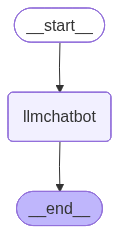

In [9]:
## Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response = graph.invoke({"messages":"Hi"})

In [11]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [12]:
for event in graph.stream({"messages": "Hi! How are you doing today?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm doing well, thanks for asking. I'm a large language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you may have. How about you? How's your day going so far?


### ChatBot

In [13]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tool.invoke("What is Langgraph")

{'query': 'What is Langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.geeksforgeeks.org/machine-learning/what-is-langgraph/',
   'title': 'What is LangGraph?',
   'content': 'LangGraph is an open-source framework built by LangChain that streamlines the creation and management of AI agent workflows. By treating workflows as interconnected nodes and edges, LangGraph offers a scalable, transparent and developer-friendly way to design advanced AI systems ranging from simple chatbots to multi-agent system. * ****Enhanced decision-making:**** Models relationships between nodes, enabling AI agents to learn from past actions and feedback. * ****langgraph:**** Framework for building graph-based AI workflows. * Build the workflow graph using LangGraph, adding nodes for classification and response, connecting them with edges and compiling the app. * Send each input through the workflow graph and returns the bot’s response, either a greeting

In [14]:
## Customer Function
def multiply(a:int, b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """

In [15]:
tools = [tool, multiply]

In [16]:
llm_with_tool = llm.bind_tools(tools)

In [17]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000014A064AB0E0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000014A064ABE00>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

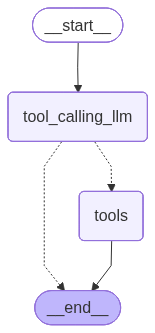

In [18]:
from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", END)

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
response = graph.invoke({"messages": "What is the recent AI News"})

In [20]:
response

{'messages': [HumanMessage(content='What is the recent AI News', additional_kwargs={}, response_metadata={}, id='e5ef291a-5437-4109-b69b-388ff0993ade'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'j6tnn3k9h', 'function': {'arguments': '{"query":"recent AI news","time_range":"day","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 1855, 'total_tokens': 1886, 'completion_time': 0.085872791, 'completion_tokens_details': None, 'prompt_time': 0.09111351, 'prompt_tokens_details': None, 'queue_time': 0.095358339, 'total_time': 0.176986301}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--9e31c1eb-cb1a-43d8-a8f2-9ff4e474d43c-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'time_range': 'day', 'topic': 'ne

In [21]:
response["messages"][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/openai-news-today-november-22-2025-foxconn-hardware-push-emirates-ai-deal-sam-altmans-memo-and-global-chatgpt-group-chats/", "title": "OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman’s Memo and Global ChatGPT Group Chats - ts2.tech", "score": 0.9970421, "published_date": "Sat, 22 Nov 2025 14:41:53 GMT", "content": "# OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman’s Memo and Global ChatGPT Group Chats On November 22, 2025, OpenAI sits at the center of several big storylines: a strategic hardware tie‑up with Foxconn, a new airline partnership with Emirates, a leaked memo from CEO Sam Altman about Google’s AI lead, the global rollout of ChatGPT group chats, and intensifying scrutiny around safety and regulation. * **Emirates Group**\xa0has confirmed a collaboration with OpenAI t

In [22]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News
================================== Ai Message ==================================
Tool Calls:
  tavily_search (j6tnn3k9h)
 Call ID: j6tnn3k9h
  Args:
    query: recent AI news
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://ts2.tech/en/openai-news-today-november-22-2025-foxconn-hardware-push-emirates-ai-deal-sam-altmans-memo-and-global-chatgpt-group-chats/", "title": "OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman’s Memo and Global ChatGPT Group Chats - ts2.tech", "score": 0.9970421, "published_date": "Sat, 22 Nov 2025 14:41:53 GMT", "content": "# OpenAI News Today, November 22, 2025: Foxconn Hardware Push, Emirates AI Deal, Sam Altman

In [23]:
## Customer Function

def multiply(a:int, b:int)->int:
    """Multiply a and b
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int    
    """

toos = [tool, multiply]

In [24]:
llm_with_tool = llm.bind_tools(tools)

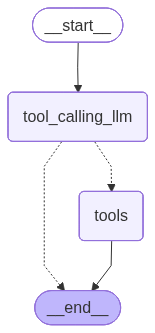

In [31]:
from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", END)

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
response =graph.invoke({"messages": "What is 5 multiply by 10"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 5 multiply by 10
================================== Ai Message ==================================
Tool Calls:
  multiply (qekp57wn2)
 Call ID: qekp57wn2
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: multiply

null


In [33]:
response =graph.invoke({"messages": "What is 15 multiply by 9, and plus 6"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is 15 multiply by 9, and plus 6
================================== Ai Message ==================================
Tool Calls:
  multiply (0xkyt4qtf)
 Call ID: 0xkyt4qtf
  Args:
    a: 15
    b: 9
  multiply (mq1cs471n)
 Call ID: mq1cs471n
  Args:
    a: 6
    b: 1
================================= Tool Message =================================
Name: multiply

null
================================= Tool Message =================================
Name: multiply

null


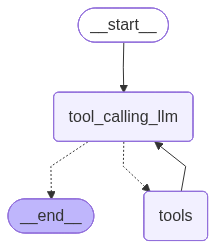

In [34]:
## ReAct Agent Architecture

from IPython.display import Image, display

# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")

# Compile the Graph
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
response =graph.invoke({"messages": "What is the recent AI News and multiply 20 by 3"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the recent AI News and multiply 20 by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search (gtaaxkzxs)
 Call ID: gtaaxkzxs
  Args:
    query: recent AI news
    search_depth: advanced
    topic: news
  multiply (jtq85mn4a)
 Call ID: jtq85mn4a
  Args:
    a: 20
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.cnbc.com/2025/11/22/new-ai-bubble-warnings-googles-comeback-and-nvidias-china-threat.html", "title": "This week in AI: Brushing off new bubble warnings, Google’s AI comeback and Nvidia’s China threat - CNBC", "score": 0.97134733, "published_date": "Sat, 22 Nov 2025 13:00:01 GMT", "content": "Meanwhile, Google on Thursday surpassed Microsoft in market cap for

### Adding Memory in Agentic Graph

In [36]:
response =graph.invoke({"messages": "Hi!, My name is Josh"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hi!, My name is Josh
================================== Ai Message ==================================

Hello Josh! It's nice to meet you. Is there something I can help you with or would you like to chat?


In [37]:
response =graph.invoke({"messages": "Hey! Remind me of my name"})
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Hey! Remind me of my name
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and I don't retain any information from previous conversations. If you'd like to share your name, I'd be happy to chat with you!


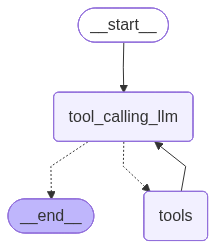

In [38]:

## ReAct Agent Architecture
# StateGraph
from langgraph.graph import StateGraph, START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Node Definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

# Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

# Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    tools_condition
)

builder.add_edge("tools", "tool_calling_llm")

# Compile the Graph
graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
config = {"configurable":{"thread_id": "1"}}

response =graph.invoke({"messages": "Hi! My name is Josh"}, config=config)

In [40]:
response

{'messages': [HumanMessage(content='Hi! My name is Josh', additional_kwargs={}, response_metadata={}, id='0de468b6-a06d-4e04-85dc-7caafc4215a9'),
  AIMessage(content="Hello Josh! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 1855, 'total_tokens': 1881, 'completion_time': 0.064734835, 'completion_tokens_details': None, 'prompt_time': 0.113140284, 'prompt_tokens_details': None, 'queue_time': 0.092797128, 'total_time': 0.177875119}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_dae98b5ecb', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--79d21e74-7b2d-4bf2-8b83-d76bdfc732ac-0', usage_metadata={'input_tokens': 1855, 'output_tokens': 26, 'total_tokens': 1881})]}

In [41]:
response["messages"][-1].content

"Hello Josh! It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [42]:
response =graph.invoke({"messages": "Hey! Remind me of my name"}, config=config)
print(response["messages"][-1].content)

Your name is Josh.


### Streaming

In [43]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
memory = MemorySaver()

In [44]:
def Chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

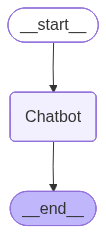

In [45]:
graph = StateGraph(State)

## Node
graph.add_node("Chatbot", chatbot)

# Edges
graph.add_edge(START, "Chatbot")
graph.add_edge("Chatbot", END)

graph_builder = graph.compile(checkpointer=memory)

## Display
display(Image(graph_builder.get_graph().draw_mermaid_png()))